# General Mixture Models

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

It is frequently the case that the data you have is not explained by a single underlying distribution. If we want to try to recover the underlying distributions, we need to have a model which has multiple components. An example is the following data.

In [5]:
from pomegranate import *
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


(array([   1.,    0.,    0.,   10.,   13.,   28.,   26.,   30.,   38.,
          28.,   21.,   21.,   21.,   20.,   85.,  149.,  151.,   77.,
          27.,    4.]),
 array([ -7.30907852,  -6.36311627,  -5.41715401,  -4.47119176,
         -3.5252295 ,  -2.57926725,  -1.633305  ,  -0.68734274,
          0.25861951,   1.20458177,   2.15054402,   3.09650628,
          4.04246853,   4.98843078,   5.93439304,   6.88035529,
          7.82631755,   8.7722798 ,   9.71824206,  10.66420431,  11.61016656]),
 <a list of 20 Patch objects>)

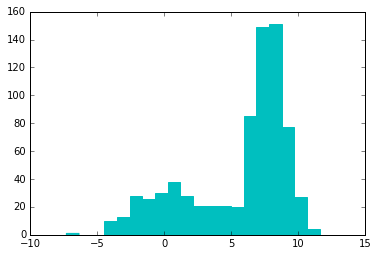

In [6]:
data = np.concatenate( (np.random.randn(250, 1) * 2.75 + 1.25, np.random.randn(500, 1) * 1.2 + 7.85) )
np.random.shuffle(data)
plt.hist( data, edgecolor='c', color='c', bins=20 )

We can create our initial estimate of what this distribution is a General Mixture Model. This is a model which is comprised of multiple distributions, and weights on those distributions representing the prior probability of a point falling under that distribution given no knowledge of the point itself (defaults to equal). We can have univariate mixture models by using univariate distributions, or multivariate distributions by using multivariate distributions.

## Gaussian Mixture Models

In [7]:
d = GeneralMixtureModel( [NormalDistribution(2.5, 1), NormalDistribution(8, 1)] )

We can now predict the class labels of each point under this mixture. 

In [8]:
labels = d.predict( data )
print labels[:5]
print "{} 1 labels, {} 0 labels".format( labels.sum(), labels.shape[0] - labels.sum() )

[1 1 1 1 0]
507 1 labels, 243 0 labels


This is fairly close to the number of underlying points from each distribution, off by 17 in each label. We still don't know if the labels are accurate, just the number of labels.

(array([  9.,   8.,  20.,  29.,  36.,  48.,  46.,  54.,  61.,  53.,  40.,
         35.,  21.,  16.,  15.,  11.,   1.,   2.,   1.,   1.]),
 array([  5.33097483,   5.64493442,   5.95889401,   6.27285359,
          6.58681318,   6.90077277,   7.21473235,   7.52869194,
          7.84265153,   8.15661111,   8.4705707 ,   8.78453029,
          9.09848987,   9.41244946,   9.72640904,  10.04036863,
         10.35432822,  10.6682878 ,  10.98224739,  11.29620698,  11.61016656]),
 <a list of 20 Patch objects>)

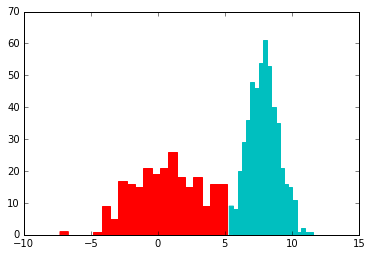

In [9]:
plt.hist( data[ labels == 0 ], edgecolor='r', color='r', bins=20 )
plt.hist( data[ labels == 1 ], edgecolor='c', color='c', bins=20 )

It is slightly more difficult to update the underlying components of the model because we don't have labels indicating which point came from which distribution. We could try to use the labels inferred from the model. It seems to cleanly split it, but what if our initial estimate was not very good? It could be difficult to get a good update if we had a bad prior. 

Another possibility is to predict the probability of each point under each component, to get a softer estimate of the labels. Lets take a look.

In [10]:
labels = d.predict_proba( data )
print labels[:5]
print labels.sum(axis=0)

[[  1.28630159e-08   9.99999987e-01]
 [  3.14180327e-10   1.00000000e+00]
 [  1.28508601e-04   9.99871491e-01]
 [  5.37380480e-07   9.99999463e-01]
 [  9.99999998e-01   2.39509083e-09]]
[ 242.73703674  507.26296326]


This is slightly closer to the truth, with 15.2 off instead of 17, around 10% closer.

This is the beginning of a common unsupervised training algorithm called <b>expectation maximization</b>. It has two steps, <b>expectation</b> and <b>maximization</b>. The <b>expectation</b> step involves what we just did--assigning weights based on the probability of each point being generated by each component. The next step, <b>maximization</b>, is maximizing the probability that the distribution generated these points but performing weighted MLE.

This process must be iterated until convergence. Sometimes this requires only a single update, but for overlapping distributions (such as this one) it can sometimes take many iterations.

In [11]:
d.fit( data, verbose=True )

Improvement: 892.969216325
Improvement: 0.786696085199
Improvement: 0.0368066512267
Total Improvement: 893.792719061


893.7927190612211

## Multivariate Gaussian Mixture Models

We can do the same with multivariate distributions just as easily.

In [12]:
mu = np.arange(5)
cov = np.eye(5)

mgs = [ MultivariateGaussianDistribution( mu*i, cov ) for i in range(5) ]
gmm = GeneralMixtureModel( mgs )

In [13]:
data = numpy.random.randn(1000, 5) * 5
for i in range(5):
    data[i::5] += np.arange(5)*i

Lets see how well some points fit under the mixture model.

In [14]:
for i in range(10):
    print "Point {}: logp {}".format( i, gmm.log_probability(data[i]) )

Point 0: logp -92.9968217129
Point 1: logp -95.9044220626
Point 2: logp -19.5299139507
Point 3: logp -28.2330753263
Point 4: logp -30.5658500441
Point 5: logp -109.57535738
Point 6: logp -54.4032830472
Point 7: logp -204.647149088
Point 8: logp -228.971188173
Point 9: logp -52.1138274966


In [15]:
gmm.fit(data, verbose=True, stop_threshold=1)

Improvement: 44541.6683755
Improvement: 30.6096878561
Improvement: 11.5923550805
Improvement: 6.24301245829
Improvement: 3.90149691583
Improvement: 2.65858549903
Improvement: 1.93523543866
Improvement: 1.50763034672
Improvement: 1.25218891462
Improvement: 1.0923188329
Improvement: 0.986870608411
Total Improvement: 44603.4477575


44603.44775749489

Now lets see how well the previous points fit.

In [16]:
for i in range(10):
    print "Point {}: logp {}".format( i, gmm.log_probability(data[i]) )

Point 0: logp -15.7580845989
Point 1: logp -16.114044174
Point 2: logp -14.0475691373
Point 3: logp -14.7997614439
Point 4: logp -14.6995141746
Point 5: logp -17.9272784665
Point 6: logp -15.3165691235
Point 7: logp -20.1189037538
Point 8: logp -22.3676868448
Point 9: logp -15.9103605907


Looks like they're being fit significantly better than before! Training works.

## Discrete Mixture Models

In addition to having general mixture models over continuous distributions, we can also have mixture models over discrete distributions. This is useful in many bioinformatics contexts, specifically sequence analysis. Lets use the toy analysis of trying to analyze CG island distribution.

The problem is the following; DNA is made up of long sequences the four canonical nucleotides, abbreviated 'A', 'C', 'G', and 'T'. These nucleotides are not distributed randomly, and there is significant amounts of structure in the sequence. A major field in bioinformatics is trying to interpret this structure. One structured element is the CG content, where the Cs and the Gs appear more commonly than in the background. If we want to try to determine CG percentages in these islands, we can use a mixture model.

In [17]:
d1 = DiscreteDistribution( {'A' : 0.25, 'C': 0.25, 'G' : 0.25, 'T': 0.25 } ) # Background
d2 = DiscreteDistribution( {'A' : 0.05, 'C': 0.45, 'G' : 0.45, 'T': 0.05 } ) # CG rich regions
gmm = GeneralMixtureModel( [d1, d2] )

In [18]:
seq = numpy.array(list('CGACATCTGACTACGGCGCGCCTACTACTTGATCGATACGGCGTCAGCGACGACGATGATCGGCATCAGTCACTAC'))
gmm.fit(seq)

3.4766541840931495

In [19]:
print gmm.distributions
print
print numpy.exp(gmm.weights)

[ {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.3500000000000001,
            "C" :0.19999999999999993,
            "T" :0.29166666666666674,
            "G" :0.15833333333333327
        }
    ],
    "name" :"DiscreteDistribution"
}
 {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.0905172413793103,
            "C" :0.46551724137931033,
            "T" :0.07543103448275859,
            "G" :0.3685344827586208
        }
    ],
    "name" :"DiscreteDistribution"
}]

[ 0.56390977  0.43609023]


Looks like in this case the concept was sound, that there many CG rich regions, but our initial estimates of the  percentages were off. We can use a GMM like the one above to both identify and study the composition of these regions at the same time, updating the parameters of the distributions using expectation-maximization. We will go into a more complex way of dong this using HMMs in the next tutorial.

## Serialization

General Mixture Models support serialization to JSONs using `to_json()` and `from_json( json )`. This is useful is you want to train a GMM on large amounts of data, taking a significant amount of time, and then use this model in the future without having to repeat this computationally intensive step.

In [20]:
print gmm.to_json()

{
    "weights" : [
        -0.5728610146854433,
        -0.8299061176753344
    ],
    "distributions" : [
        {
            "frozen" : false,
            "class" : "Distribution",
            "parameters" : [
                {
                    "A" : 0.3500000000000001,
                    "C" : 0.19999999999999993,
                    "T" : 0.29166666666666674,
                    "G" : 0.15833333333333327
                }
            ],
            "name" : "DiscreteDistribution"
        },
        {
            "frozen" : false,
            "class" : "Distribution",
            "parameters" : [
                {
                    "A" : 0.0905172413793103,
                    "C" : 0.46551724137931033,
                    "T" : 0.07543103448275859,
                    "G" : 0.3685344827586208
                }
            ],
            "name" : "DiscreteDistribution"
        }
    ],
    "class" : "GeneralMixtureModel"
}


Not the prettiest thing to look at right now. However, we can easily load it and use it immediately.

In [21]:
gmm_2 = GeneralMixtureModel.from_json( gmm.to_json() )
gmm_2.distributions

array([ {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.3500000000000001,
            "C" :0.19999999999999993,
            "T" :0.29166666666666674,
            "G" :0.15833333333333327
        }
    ],
    "name" :"DiscreteDistribution"
},
       {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "A" :0.0905172413793103,
            "C" :0.46551724137931033,
            "T" :0.07543103448275859,
            "G" :0.3685344827586208
        }
    ],
    "name" :"DiscreteDistribution"
}], dtype=object)

`gmm_2` is now ready to go, as if it was the original model!

## Concluding Remarks

General Mixture Models are extremely powerful tools for unsupervised learning. pomegranate makes it easy to define, fit, and make predictions using these models. All the examples above have used the same distribution type for all the components of the mixture, but that is not a requirement, if your application requires varied distributions.